# `pyroomacoustics` demo

In this IPython notebook, we demonstrate a few features of `pyroomacoustics`:

1. Its _pythonic_ and convenient object-oriented interface.
2. The Room Impulse Response (RIR) generator.
3. Provided reference algorithms. 

Below is a list of the examples (run all cells as some may depend on previous imports and results). 

1. [Creating a 2D/3D room](#room)
2. [Adding sources and microphones](#source_mic)
3. [Room Impulse Response generation and propagation simulation](#rir)
4. [Beamforming](#bf)
5. [Direction-of-arrival](#doa)
6. [Adaptive filtering](#af)
7. [STFT processing](#stft)
8. [Source Separation](#bss)

More information on the package can be found on the [Github repo](https://github.com/LCAV/pyroomacoustics) and from the [paper](https://arxiv.org/pdf/1710.04196.pdf), which can be cited as:

_R. Scheibler, E. Bezzam, I. Dokmanić, Pyroomacoustics: A Python package for audio room simulations and array processing algorithms, Proc. IEEE ICASSP, Calgary, CA, 2018._

Let's begin by importing the necessary libraries all of which can be installed with `pip`, even `pyroomacoustics`!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

<a id='room'></a>
## Creating a 2D/3D room

We can build an arbitrary room by specifing its corners on a plane.

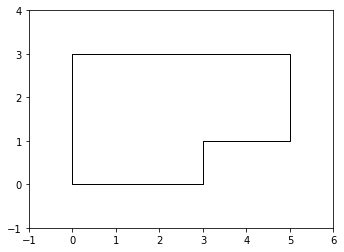

In [2]:
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

If we wish to build a 3D room, we can "lift" the 2D shape by a specified height.

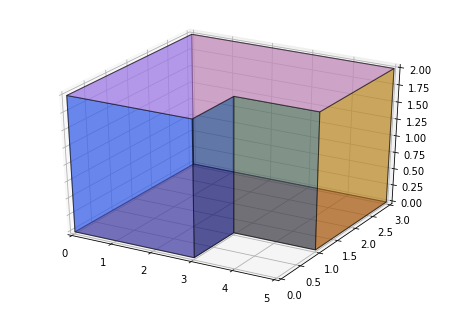

In [3]:
room = pra.Room.from_corners(corners)
room.extrude(2.)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

<a id='source_mic'></a>
## Adding sources and microphones

We can conveniently add sources to the room using the `add_source` method. We can also set a `numpy` array as the source's signal.

The speech file comes from the [CMU Arctic Database](http://www.festvox.org/cmu_arctic/).

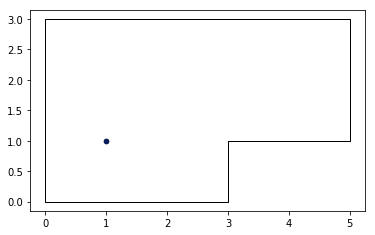

In [4]:
# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs)
room.add_source([1.,1.], signal=signal)

fig, ax = room.plot()

And similarly add a microphone array.

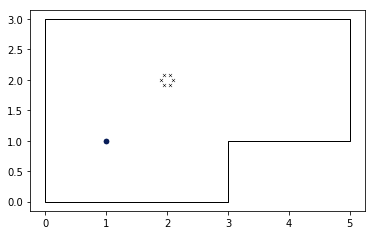

In [5]:
R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()

<a id='rir'></a>
## Room impulse response (RIR) generation and propagation simulation

Using the Image Source Model (ISM) we can compute the impulse response for each microphone. From the `Room` constructor it is possible to set the maximum ISM order and the absorption coefficient.

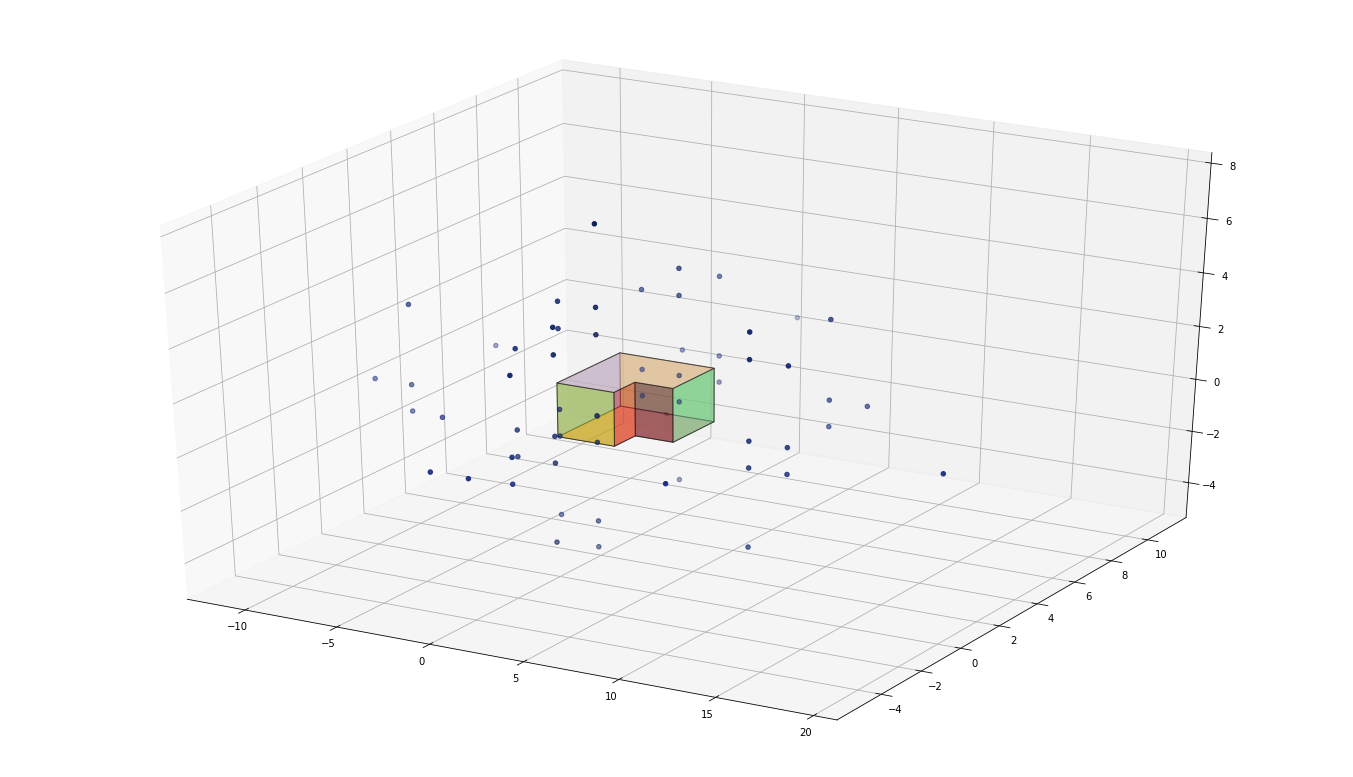

In [6]:
# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=8, absorption=0.2)
room.extrude(2.)

# add source and set the signal to WAV file content
room.add_source([1., 1., 0.5], signal=signal)

# add two-microphone array
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])  # [[x], [y], [z]]
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

# compute image sources
room.image_source_model(use_libroom=True)

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=3)
fig.set_size_inches(18.5, 10.5)

Moreover, we can plot the RIR for each microphone once the image sources have been computed.

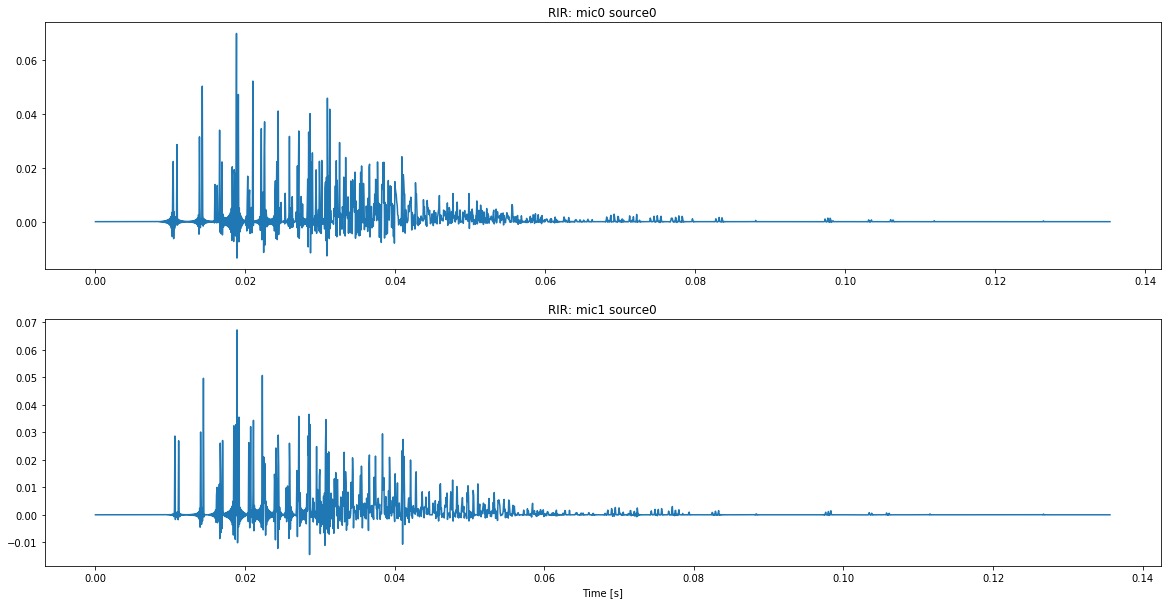

In [7]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

Moreover, we can simulate our signal convolved with these impulse responses as such:

In [8]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 59210)


Let's listen to the output!

In [9]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [10]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


<a id='bf'></a>
## Beamforming

Reference implementations of beamforming are also provided. Fixed weight beamforming is possible in both the time and frequency domain. Classic beamforming algorithms are included as special cases of the _acoustic rake receivers_, namely by including only the direct source we obtain DAS and MVDR beamformers.

The noise file comes from [Google's Speech Command dataset](www.tensorflow.org/versions/master/tutorials/audio_recognition).

/Users/eric/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


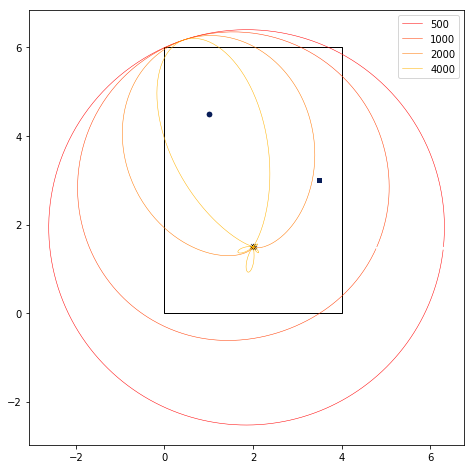

In [11]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples

# specify signal and noise source
fs, signal = wavfile.read("arctic_a0010.wav")
fs, noise = wavfile.read("exercise_bike.wav")  # may spit out a warning when reading but it's alright!

# Create 4x6 shoebox room with source and interferer and simulate
room_bf = pra.ShoeBox([4,6], fs=fs, max_order=12)
source = np.array([1, 4.5])
interferer = np.array([3.5, 3.])
room_bf.add_source(source, delay=0., signal=signal)
room_bf.add_source(interferer, delay=0., signal=noise[:len(signal)])

# Create geometry equivalent to Amazon Echo
center = [2, 1.5]; radius = 37.5e-3
fft_len = 512
echo = pra.circular_2D_array(center=center, M=6, phi0=0, radius=radius)
echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)
mics = pra.Beamformer(echo, room_bf.fs, N=fft_len, Lg=Lg)
room_bf.add_microphone_array(mics)

# Compute DAS weights
mics.rake_delay_and_sum_weights(room_bf.sources[0][:1])

# plot the room and resulting beamformer before simulation
fig, ax = room_bf.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])
fig.set_size_inches(20, 8)

Let's simulate the propagation and listen to the center microphone.

In [12]:
room_bf.compute_rir()
room_bf.simulate()
print("Center Mic:")
IPython.display.Audio(room_bf.mic_array.signals[-1,:], rate=fs)

Center Mic:


Now let's see how simple DAS beamforming can improve the result.

In [13]:
signal_das = mics.process(FD=False)
print("DAS Beamformed Signal:")
IPython.display.Audio(signal_das, rate=fs)

DAS Beamformed Signal:


We can certainly hear that the noise at higher frequencies, where we have better directivity, is noticeable attenuated!

<a id='doa'></a>
## Direction of Arrival

Several reference algorithms for direction-of-arrival (DOA) estimation are provided. These methods work in the frequency domain of which there are generally two types: incoherent and coherent methods.

We provide the following algorithms: SRP-PHAT, MUSIC, CSSM, WAVES, TOPS, and FRIDA.

Let's perform DOA for two sources.

In [14]:
# Location of sources
azimuth = np.array([61., 270.]) / 180. * np.pi
distance = 2.  # meters

A few constants and parameters for the algorithm such as the FFT size and the frequency range over which to perform DOA.

In [15]:
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]

Let's build a 2D room where we will perform our simulation.

In [16]:
snr_db = 5.    # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

# Create an anechoic room
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

As in the Beamforming example, we will use an array geometry equivalent to that of an Amazon Echo.

In [17]:
echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)
aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

We'll create two synthetic signals and add them to the room at the specified locations with respect to the array.

In [18]:
# Add sources of 1 second duration
rng = np.random.RandomState(23)
duration_samples = int(fs)

for ang in azimuth:
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    source_signal = rng.randn(duration_samples)
    aroom.add_source(source_location, signal=source_signal)
    
# Run the simulation
aroom.simulate()

The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [19]:
X = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in aroom.mic_array.signals])

Now let's compare a few algorithms!

In [20]:
algo_names = ['SRP', 'MUSIC', 'FRIDA', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](echo, fs, nfft, c=c, num_src=2, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    if algo_name is 'FRIDA':
        spatial_resp[algo_name] = np.abs(doa._gen_dirty_img())
    else:
        spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)

Let's plot the estimated spatial spectra and compare it with the true locations!

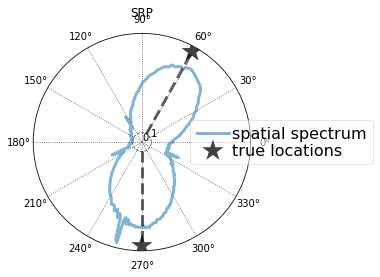

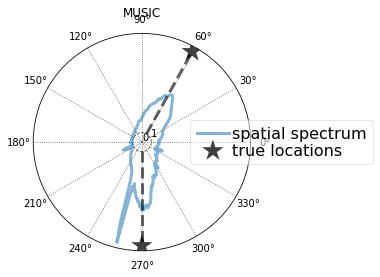

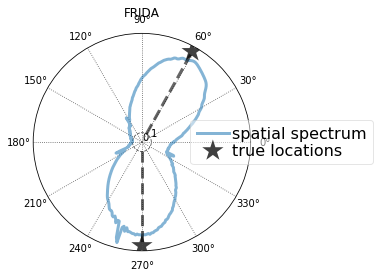

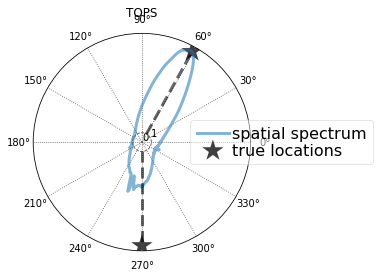

In [21]:
# plotting param
base = 1.
height = 10.
true_col = [0, 0, 0]

# loop through algos
phi_plt = doa.grid.azimuth
for algo_name in algo_names:
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c_phi_plt = np.r_[phi_plt, phi_plt[0]]
    c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
    ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
            alpha=0.55, linestyle='-',
            label="spatial spectrum")
    plt.title(algo_name)
    
    # plot true loc
    for angle in azimuth:
        ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
            color=true_col, alpha=0.6)
    K = len(azimuth)
    ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
               (K, 1)), s=500, alpha=0.75, marker='*',
               linewidths=0,
               label='true locations')

    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.5,
              scatterpoints=1, loc='center right', fontsize=16,
              ncol=1, bbox_to_anchor=(1.6, 0.5),
              handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.set_yticks(np.linspace(0, 1, 2))
    ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
    ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
    ax.set_ylim([0, 1.05 * (base + height)]);

plt.show()

<a id='af'></a>
## Adaptive Filtering

Implementations of LMS, NLMS, and RLS are also available in `pyroomacoustics`. They share a similar constructor and interface as shown below.

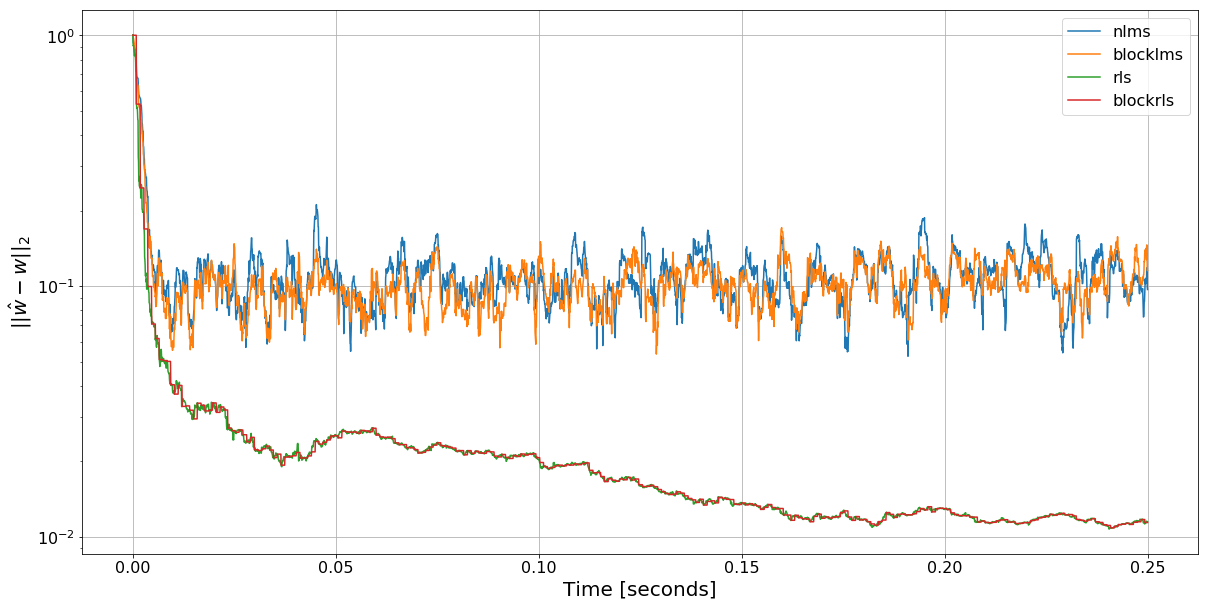

In [22]:
# parameters
length = 15        # the unknown filter length
n_samples = 4000   # the number of samples to run
SNR = 15           # signal to noise ratio
fs = 16000

# the unknown filter (unit norm)
w = np.random.randn(length)
w /= np.linalg.norm(w)

# create a known driving signal
x = np.random.randn(n_samples)

# convolve with the unknown filter
d_clean = fftconvolve(x, w)[:n_samples]

# add some noise to the reference signal
d = d_clean + np.random.randn(n_samples) * 10**(-SNR / 20.)

# create a bunch adaptive filters
adfilt = dict(
    nlms=dict(
        filter=pra.adaptive.NLMS(length, mu=0.5), 
        error=np.zeros(n_samples),
        ),
    blocklms=dict(
        filter=pra.adaptive.BlockLMS(length, mu=1./15./2.), 
        error=np.zeros(n_samples),
        ),
    rls=dict(
        filter=pra.adaptive.RLS(length, lmbd=1., delta=2.0),
        error=np.zeros(n_samples),
        ),
    blockrls=dict(
        filter=pra.adaptive.BlockRLS(length, lmbd=1., delta=2.0),
        error=np.zeros(n_samples),
        ),
    )

for i in range(n_samples):
    for algo in adfilt.values():
        algo['filter'].update(x[i], d[i])
        algo['error'][i] = np.linalg.norm(algo['filter'].w - w)

plt.figure()
for algo in adfilt.values():
    plt.semilogy(np.arange(n_samples)/fs, algo['error'])
plt.legend(adfilt, fontsize=16)
plt.ylabel("$\||\hat{w}-w\||_2$", fontsize=20)
plt.xlabel("Time [seconds]", fontsize=20)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.grid()
fig = plt.gcf()
fig.set_size_inches(20, 10)

<a id='stft'></a>
## Short Time Fourier Transform (STFT) processing

While there is an STFT module supporting overlap-add, zero-padding, and analysis/synthesis windows:

1. Analysis : ```pra.stft.stft(x, L, hop, transform=np.fft.fft, win=None, zp_back=0, zp_front=0)```
2. Synthesis : ```pra.stft.istft(X, L, hop, transform=np.fft.ifft, win=None, zp_back=0, zp_front=0)```

It performs the analysis and synthesis operations on the entire signal. The ```pra.realtime.STFT``` class is more suitable for streaming / real-time data, can be applied to multi-channel, and can be used for applying frequency domain processing.

In [23]:
# filter to apply (moving average / low pass)
h_len = 50
h = np.ones(h_len)
h /= np.linalg.norm(h)

# stft parameters
fft_len = 512
block_size = fft_len - h_len + 1  # make sure the FFT size is a power of 2
hop = block_size // 2  # half overlap
window = pra.hann(block_size, flag='asymmetric', length='full') 

# Create the STFT object + set filter and appropriate zero-padding
stft = pra.realtime.STFT(block_size, hop=hop, analysis_window=window, channels=1)
stft.set_filter(h, zb=h.shape[0] - 1)   

Simulate streaming audio.

/Users/eric/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7221: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


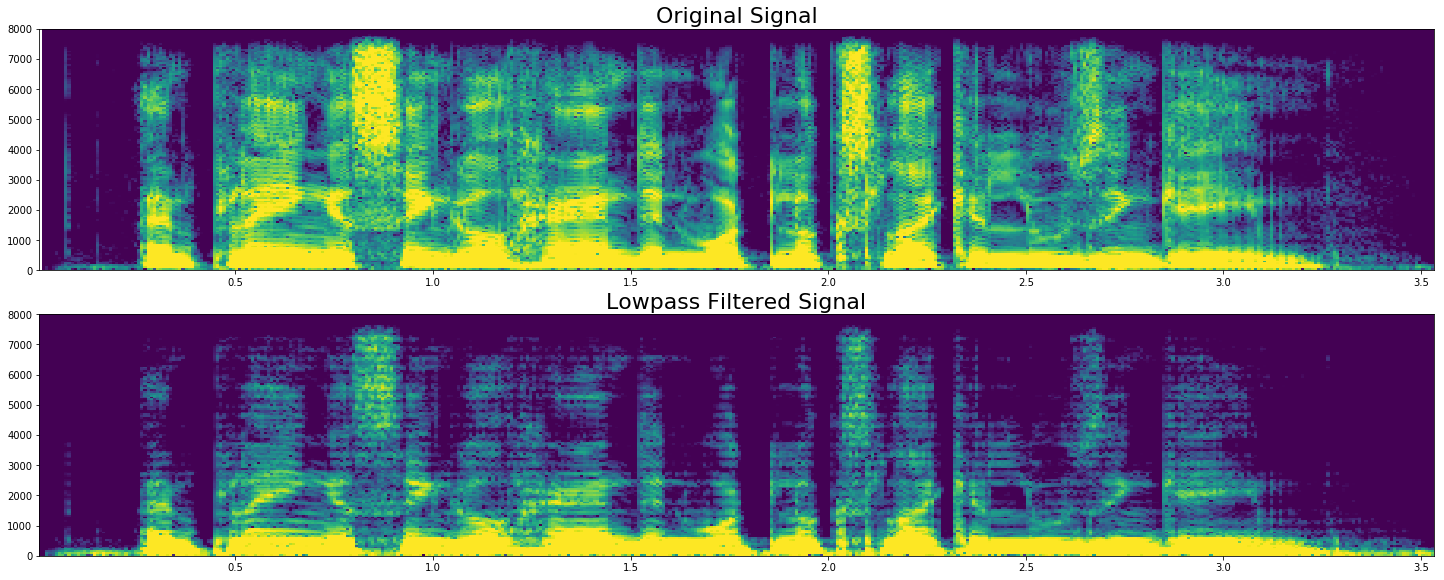

In [24]:
fs, signal = wavfile.read("arctic_a0010.wav")

processed_audio = np.zeros(signal.shape)
n = 0
while  signal.shape[0] - n > hop:

    stft.analysis(signal[n:n+hop,])
    stft.process()  # apply the filter
    processed_audio[n:n+hop,] = stft.synthesis()
    n += hop
    
# plot the spectrogram before and after filtering
fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(2,1,1)
plt.specgram(signal[:n-hop].astype(np.float32), NFFT=256, Fs=fs, vmin=-20, vmax=30)
plt.title('Original Signal', fontsize=22)
plt.subplot(2,1,2)
plt.specgram(processed_audio[hop:n], NFFT=256, Fs=fs, vmin=-20, vmax=30)
plt.title('Lowpass Filtered Signal', fontsize=22)
plt.tight_layout(pad=0.5)
plt.show()

Let's compare the low-pass filtered signal with the original.

In [25]:
print("Original:")
IPython.display.Audio(signal, rate=fs)

Original:


In [26]:
print("LPF'ed:")
IPython.display.Audio(processed_audio, rate=fs)

LPF'ed:


<a id='bss'></a>
## Blind Source Separation (BSS)

Blind Source Separation techniques such as Independent Vector Analysis (IVA) using an Auxiliary function are implemented in ´pyroomacoustics´. IVA based algorithms work when the number of microphones is the same as the number of sources, i.e., the determinant case. Through this example, we will deal with the case of 2 sources and 2 microphones. 

First, open and concatanate wav files from the CMU dataset.

In [27]:
# concatanate audio samples to make them look long enough
wav_files = [
        ['../examples/input_samples/cmu_arctic_us_axb_a0004.wav',
            '../examples/input_samples/cmu_arctic_us_axb_a0005.wav',
            '../examples/input_samples/cmu_arctic_us_axb_a0006.wav',],
        ['../examples/input_samples/cmu_arctic_us_aew_a0001.wav',
            '../examples/input_samples/cmu_arctic_us_aew_a0002.wav',
            '../examples/input_samples/cmu_arctic_us_aew_a0003.wav',]
        ]

signals = [ np.concatenate([wavfile.read(f)[1].astype(np.float32)
        for f in source_files])
for source_files in wav_files ]

 Define an anechoic room envrionment, as well as the microphone array and source locations.

In [28]:
# Room 4m by 6m
room_dim = [8, 9]

# source locations and delays
locations = [[2.5,3], [2.5, 6]]
delays = [1., 0.]

# create an anechoic room with sources and mics
room = pra.ShoeBox(room_dim, fs=16000, max_order=15, absorption=0.35, sigma2_awgn=1e-8)

# add mic and good source to room
# Add silent signals to all sources
for sig, d, loc in zip(signals, delays, locations):
    room.add_source(loc, signal=np.zeros_like(sig), delay=d)

# add microphone array
room.add_microphone_array(pra.MicrophoneArray(np.c_[[6.5, 4.49], [6.5, 4.51]], room.fs))

Compute the RIRs as in the [Room Impulse Response generation](#rir) section.

In [29]:
# compute RIRs
room.compute_rir()

Mix the microphone recordings to simulate the observed signals by the microphone array in the frequency domain. To that end, we apply the STFT transform as explained in [STFT](#stft).

In [30]:
from mir_eval.separation import bss_eval_images

# Record each source separately
separate_recordings = []
for source, signal in zip(room.sources, signals):

    source.signal[:] = signal

    room.simulate()
    separate_recordings.append(room.mic_array.signals)

    source.signal[:] = 0.
separate_recordings = np.array(separate_recordings)

# Mix down the recorded signals
mics_signals = np.sum(separate_recordings, axis=0)

# STFT frame length
L = 2048
# Observation vector in the STFT domain
X = np.array([pra.stft(ch, L, L, transform=np.fft.rfft, zp_front=L//2, zp_back=L//2) for ch in mics_signals])
X = np.moveaxis(X, 0, 2)

# Reference signal to calculate performance of BSS
ref = np.moveaxis(separate_recordings, 1, 2)
SDR, SIR = [], []

# Callback function to monitor the convergence of the algorithm
def convergence_callback(Y):
    global SDR, SIR
    ref = np.moveaxis(separate_recordings, 1, 2)
    y = np.array([pra.istft(Y[:,:,ch], L, L,
            transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])
    sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])
    SDR.append(sdr)
    SIR.append(sir)

Run AuxIVA to estimate the source images from the observation signals in the frequency domain.

In [31]:
import sys, os
sys.path.append(os.path.join("..", "pyroomacoustics"))
from bss import auxiva

# Run AuxIVA
Y = auxiva(X, n_iter=30, proj_back=True, callback=convergence_callback)

Apply the inverse STFT to return to the time domain, where we can compare the separated signals with the reference signal.

In [32]:
# run iSTFT
y = np.array([pra.istft(Y[:,:,ch], L, L, transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])

# Compare SIR and SDR with our reference signal
sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])

Visualize the results by plotting the spectrograms and the Signal to Distortion Ratio (SDR) and Signal to Interference Ratio (SIR) source separation performance metrics in decibels (dB).

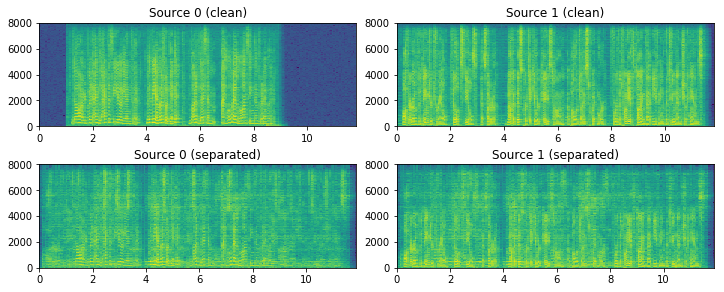

In [33]:
fig = plt.figure()
fig.set_size_inches(10,  4)

plt.subplot(2,2,1)
plt.specgram(ref[0,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (clean)')

plt.subplot(2,2,2)
plt.specgram(ref[1,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (clean)')

plt.subplot(2,2,3)
plt.specgram(y[perm[0],:], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (separated)')

plt.subplot(2,2,4)
plt.specgram(y[perm[1],:], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (separated)')

plt.tight_layout(pad=0.5)

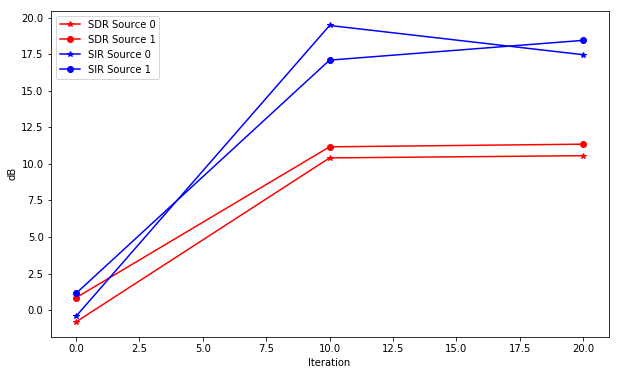

In [34]:
fig = plt.figure()
fig.set_size_inches(10, 6)
a = np.array(SDR)
b = np.array(SIR)
plt.plot(np.arange(a.shape[0]) * 10, a[:,0], label='SDR Source 0', c='r', marker='*')
plt.plot(np.arange(a.shape[0]) * 10, a[:,1], label='SDR Source 1', c='r', marker='o')
plt.plot(np.arange(b.shape[0]) * 10, b[:,0], label='SIR Source 0', c='b', marker='*')
plt.plot(np.arange(b.shape[0]) * 10, b[:,1], label='SIR Source 1', c='b', marker='o')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('dB')

plt.show()

Finally, listen to the mixed signal and the separated audio sources.

In [35]:
print("Mixed signal:")
IPython.display.Audio(mics_signals[0], rate=fs)

Mixed signal:


In [36]:
print("Separated source 0:")
IPython.display.Audio(y[0], rate=fs)

Separated source 0:


In [37]:
print("Separated source 1:")
IPython.display.Audio(y[1], rate=fs)

Separated source 1:
